# Decision Tree Algorithm with Bag of Words and TFIDF

### Importing the important libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about

from tqdm import tqdm
import os

#### Importing the dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

## Calculating sentiment scores of essay using nltk

In [3]:
# Importing nltk and SentimentIntensityAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chanchal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# Initalizing SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [6]:
# Storing essay from the dataframe in a variable 'essay'
preprocessed_review_text = df['preprocessed_review_text']

In [7]:
# Getting polarity scores for each essay and storing it in a dictionary
scores_dict = df['preprocessed_review_text'].apply(lambda essay:sid.polarity_scores(str(essay)))

In [8]:
# Converting the dictionary to a dataframe, this will be used to merge with our main dataframe
df1=pd.DataFrame.from_records(scores_dict)

In [9]:
# Checking the head of the new dataframe
df1.head(1)

,neg,neu,pos,compound
0,0.0,0.093,0.907,0.8658


In [10]:
# Merging the main dataframe with the new dataframe
df=pd.merge(df, df1, left_index=True, right_index=True)

In [11]:
# The dataframe that will be used in our further analysis
df.head(1)

,Unnamed: 0,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


### Splitting data into Train and Test: Stratified Sampling

In [12]:
# Segregating the dependent and independent variables as y and X respectively
y = df['Review_Rating_Score'].values
X = df.drop(['Review_Rating_Score','Unnamed: 0'], axis=1)
X.head(1)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


In [13]:
# Splitting the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [14]:
# Printing the shape of the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(841, 17) (841,)
(281, 17) (281,)


# Bag of Words

### Review Text

In [15]:
# Implementing Bag of Words
vectorizer_bow = CountVectorizer(min_df=5)

In [16]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow.fit(X_train['preprocessed_review_text'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [17]:
# Applying transform method on train and test set
X_train_review_text_bow = vectorizer_bow.transform(X_train['preprocessed_review_text'].values)

In [18]:
X_test_review_text_bow = vectorizer_bow.transform(X_test['preprocessed_review_text'].values)

In [19]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_text_bow.shape, y_train.shape)
print(X_test_review_text_bow.shape, y_test.shape)

After vectorizations
(841, 578) (841,)
(281, 578) (281,)


In [20]:
X_train.head(2)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
120,123,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hugger-52-in-LED-I...,brand_not_mentioned,49.97,https://www.homedepot.com/ReviewServices/revie...,2018-09-19,noise,hugger_52_led_indoor_brushed_nickel_ceiling_fa...,noise,0.000,1.000,0.000,0.0000
1094,1160,Lowes,lighting_&_ceiling_fans,ceiling_fans_&_accessories,ceiling_fans,https://www.lowes.com/pd/Hunter-Creekside-LED-...,hunter,99.98,https://www.lowes.com/pd/Hunter-Creekside-LED-...,2019-08-08,hunter great attention details like rubber dam...,hunter_creekside_led_52_satin_nickel_led_indoo...,pretty great air flow silent,0.061,0.606,0.333,0.8402


### Review_Header

In [21]:
# Implementing Bag of Words
vectorizer_bow_rh = CountVectorizer(min_df=5)

In [22]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow_rh.fit(X_train['preprocessed_review_header'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [23]:
# Applying transform method on train and test set
X_train_review_header_bow = vectorizer_bow_rh.transform(X_train['preprocessed_review_header'].values)

In [24]:
X_test_review_header_bow = vectorizer_bow_rh.transform(X_test['preprocessed_review_header'].values)

In [25]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_header_bow.shape, y_train.shape)
print(X_test_review_header_bow.shape, y_test.shape)

After vectorizations
(841, 115) (841,)
(281, 115) (281,)


## Encoding Numerical and Categorical Features

#### Encoding Categorical Feature: Retailer

In [26]:
vectorizer_r = CountVectorizer()
vectorizer_r.fit(X_train['Retailer'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_retailer_ohe = vectorizer_r.transform(X_train['Retailer'].values)
X_test_retailer_ohe = vectorizer_r.transform(X_test['Retailer'].values)

print("After vectorizations")
print(X_train_retailer_ohe.shape, y_train.shape)
print(X_test_retailer_ohe.shape, y_test.shape)
print(vectorizer_r.get_feature_names())
print("="*100)

After vectorizations
(841, 2) (841,)
(281, 2) (281,)
['homedepot', 'lowes']


#### Encoding Categorical Feature: Division

In [27]:
vectorizer_d = CountVectorizer()
vectorizer_d.fit(X_train['Division'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_division_ohe = vectorizer_d.transform(X_train['Division'].values)
X_test_division_ohe = vectorizer_d.transform(X_test['Division'].values)

print("After vectorizations")
print(X_train_division_ohe.shape, y_train.shape)
print(X_test_division_ohe.shape, y_test.shape)
print(vectorizer_d.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_ceiling_fans', 'lighting', 'lighting_']


#### Encoding Categorical Feature: Category

In [28]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(X_train['Category'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category_ohe = vectorizer_d.transform(X_train['Category'].values)
X_test_category_ohe = vectorizer_d.transform(X_test['Category'].values)

print("After vectorizations")
print(X_train_category_ohe.shape, y_train.shape)
print(X_test_category_ohe.shape, y_test.shape)
print(vectorizer_c.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_accessories', 'ceiling_fans', 'ceiling_fans_']


#### Encoding Categorical Feature: Department

In [29]:
vectorizer_de = CountVectorizer()
vectorizer_de.fit(X_train['Department'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_department_ohe = vectorizer_d.transform(X_train['Department'].values)
X_test_department_ohe = vectorizer_d.transform(X_test['Department'].values)

print("After vectorizations")
print(X_train_department_ohe.shape, y_train.shape)
print(X_test_department_ohe.shape, y_test.shape)
print(vectorizer_de.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['ceiling_fans', 'ceiling_fans_with_lights', 'ceiling_fans_without_lights']


#### Encoding Categorical Feature: Brand

In [30]:
vectorizer_b = CountVectorizer()
vectorizer_b.fit(X_train['Brand'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_brand_ohe = vectorizer_d.transform(X_train['Brand'].values)
X_test_brand_ohe = vectorizer_d.transform(X_test['Brand'].values)

print("After vectorizations")
print(X_train_brand_ohe.shape, y_train.shape)
print(X_test_brand_ohe.shape, y_test.shape)
print(vectorizer_b.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['brand_not_mentioned', 'fanimation_studio_collection', 'hampton_bay', 'harbor_breeze', 'home_decorators_collection', 'hunter', 'kichler']


#### Encoding Categorical Feature: preprocessed_product_name

In [31]:
vectorizer_pn = CountVectorizer()
vectorizer_pn.fit(X_train['preprocessed_product_name'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pn_ohe = vectorizer_pn.transform(X_train['preprocessed_product_name'].values)
X_test_pn_ohe = vectorizer_pn.transform(X_test['preprocessed_product_name'].values)

print("After vectorizations")
print(X_train_pn_ohe.shape, y_train.shape)
print(X_test_pn_ohe.shape, y_test.shape)
print(vectorizer_pn.get_feature_names())
print("="*100)

After vectorizations
(841, 77) (841,)
(281, 77) (281,)
['altura_60_outdoor_oil_rubbed_bronze_ceiling_fan', 'altura_68_indoor_oil_rubbed_bronze_ceiling_fan_remote_control', 'antero_46_led_indoor_brushed_nickel_ceiling_fan_light', 'ashby_park_44_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit', 'ashby_park_52_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit_remote_control', 'bellina_42_oil_rubbed_bronze_ceiling_fan_led_light_kit', 'brette_23_led_indoor_outdoor_brushed_nickel_ceiling_fan_light_kit_remote_control', 'brookhurst_52_led_indoor_white_ceiling_fan_light_kit', 'channelside_52_led_indoor_outdoor_noble_bronze_ceiling_fan_remote_control', 'channing_54_led_indoor_easy_install_noble_bronze_ceiling_fan_hunterexpress_feature_set', 'clarkston_ii_44_led_indoor_brushed_nickel_ceiling_fan_light_kit', 'connor_54_led_brushed_nickel_dual_mount_ceiling_fan_light_kit_remote_control', 'ellard_52_led_matte_black_indoor_ceiling_fan_lights', 'fanimati

#### Encoding Numerical Feature: Price

In [32]:
from sklearn.preprocessing import Normalizer
normalizer_pr = Normalizer()

normalizer_pr.fit(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying fit method on train data after reshaping the data

X_train_price_norm = normalizer_pr.transform(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying transform method on train and test
X_test_price_norm = normalizer_pr.transform(X_test['Final_Price_after_Discount'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neg

In [33]:
from sklearn.preprocessing import Normalizer
normalizer_neg = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neg.fit(X_train['neg'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neg_norm = normalizer_neg.transform(X_train['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer_neg.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neu

In [34]:
from sklearn.preprocessing import Normalizer
normalizer_neu = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neu.fit(X_train['neu'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neu_norm = normalizer_neu.transform(X_train['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer_neu.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: pos

In [35]:
from sklearn.preprocessing import Normalizer
normalizer_pos = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_pos.fit(X_train['pos'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_pos_norm = normalizer_pos.transform(X_train['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer_pos.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: compound

In [36]:
from sklearn.preprocessing import Normalizer
normalizer_com = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_com.fit(X_train['compound'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_com_norm = normalizer_com.transform(X_train['compound'].values.reshape(-1,1))
X_test_com_norm = normalizer_com.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_com_norm.shape, y_train.shape)
print(X_test_com_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


### Concatinating all the features

In [37]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_review_text_bow,X_train_review_header_bow, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_com_norm)).tocsr()
X_te_bow = hstack((X_test_review_text_bow,X_test_review_header_bow, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_com_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_te_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 789) (841,)
(281, 789) (281,)


In [38]:
# Importing required libraries
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_auc_score

In [39]:
# Initializing decision tree and hyper-parameters to be included in grid search cv
dt_bow = tree.DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5,10,100,500]}

In [40]:
# Grid search cv using the mentioned parameters
clf_bow = GridSearchCV(dt_bow, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf_bow.fit(X_tr_bow, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [41]:
# Let's store the results of CV in a pandas dataframe
results = pd.DataFrame.from_dict(clf_bow.cv_results_)

In [42]:
# Let us sort values based of the param_alpha column which will sort values in ascending order of alpha
results = results.sort_values(['param_max_depth'])

Text(33.0, 0.5, 'Min Sample Split')

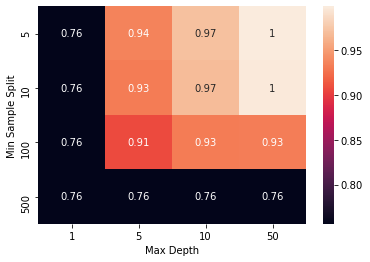

In [43]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_min_samples_split", "param_max_depth", "mean_train_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Max Depth')
plt.ylabel('Min Sample Split')

Text(33.0, 0.5, 'Min Sample Split')

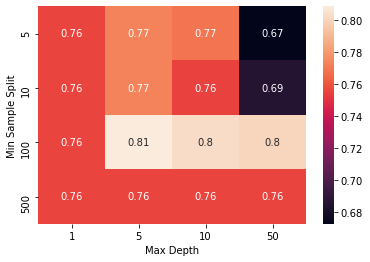

In [44]:
# Heatmap between Max Depth and Min Sample Split on Test Data
test_auc_heatmap = results.pivot("param_min_samples_split", "param_max_depth", "mean_test_score")
ax = sns.heatmap(test_auc_heatmap, annot=True)
plt.xlabel('Max Depth')
plt.ylabel('Min Sample Split')

In [45]:
# Best hyperparameters identified from the above test heatmap
best_max_depth = 10
best_min_samples_split = 100

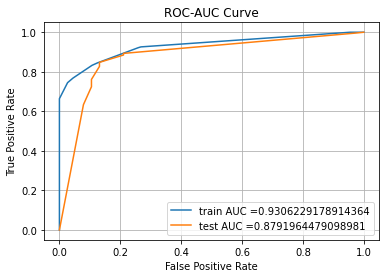

In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# Final Decision Tree model using the best hyperparameters
dt_final_tfidf = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, class_weight='balanced')
dt_final_tfidf.fit(X_tr_bow, y_train)

y_train_pred = dt_final_tfidf.predict_proba(X_tr_bow)[:,1]   
y_test_pred = dt_final_tfidf.predict_proba(X_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
#plt.xscale('log')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [47]:
# we are writing our own function to predict, with defined thresold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [48]:
# Printing confusion matrix
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7434352341759749 for threshold 0.508
Train confusion matrix
[[100  12]
 [122 607]]
Test confusion matrix
[[ 33   5]
 [ 42 201]]


In [49]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### Train Confusion Matrix

Text(33.0, 0.5, 'Actual')

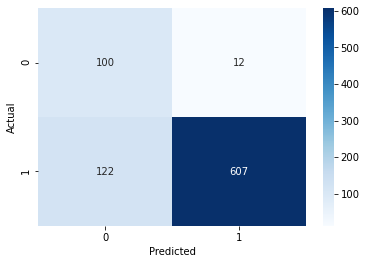

In [50]:
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Test Confusion Matrix

Text(33.0, 0.5, 'Actual')

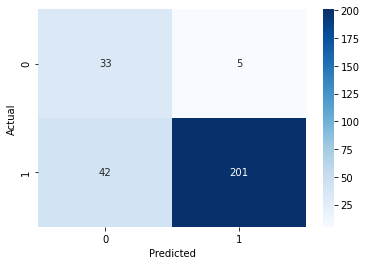

In [51]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [52]:
len(X_test['preprocessed_review_text'])

281

In [53]:
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
fpi = []
for i in range(len(y_test)) :
  if (y_test[i] == 0) & (y_test_pred[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['preprocessed_review_text'].values[i])

### Word Cloud of Review Text

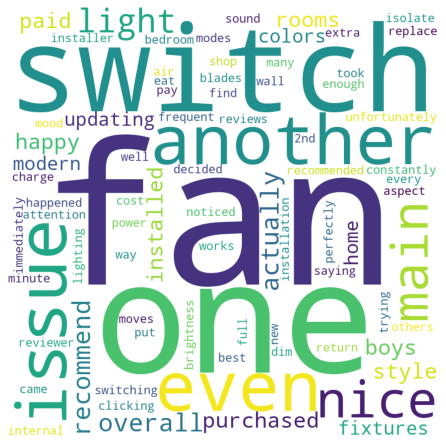

In [54]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [55]:
X_test_FP=X_test.iloc[fpi]

### Box Plot of Price after discount

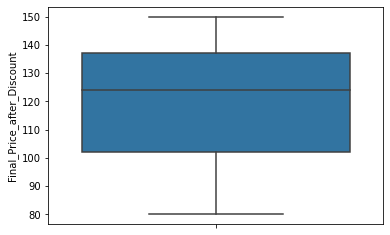

In [56]:
##Box Plot
sns.boxplot(y='Final_Price_after_Discount', data=X_test_FP)

# TFIDF

### Review_Text

In [57]:
# Implementing TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=5)
vectorizer_tfidf.fit(X_train['preprocessed_review_text'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [58]:
# Transform method on train and test data
X_train_rt_tfidf = vectorizer_tfidf.transform(X_train['preprocessed_review_text'].values)

In [59]:
X_test_rt_tfidf = vectorizer_tfidf.transform(X_test['preprocessed_review_text'].values)

In [60]:
print("After vectorizations")
print(X_train_rt_tfidf.shape, y_train.shape)
print(X_test_rt_tfidf.shape, y_test.shape)

After vectorizations
(841, 578) (841,)
(281, 578) (281,)


### Review_Header

In [61]:
# Implementing TF-IDF
vectorizer_tfidf_rh = TfidfVectorizer(min_df=5)
vectorizer_tfidf_rh.fit(X_train['preprocessed_review_header'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [62]:
# Transform method on train and test data
X_train_rh_tfidf = vectorizer_tfidf_rh.transform(X_train['preprocessed_review_header'].values)

In [63]:
X_test_rh_tfidf = vectorizer_tfidf_rh.transform(X_test['preprocessed_review_text'].values)

In [64]:
print("After vectorizations")
print(X_train_rh_tfidf.shape, y_train.shape)
print(X_test_rh_tfidf.shape, y_test.shape)

After vectorizations
(841, 115) (841,)
(281, 115) (281,)


### Concatinating all the features

In [65]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_rt_tfidf,X_train_rh_tfidf, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm,X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_com_norm)).tocsr()
X_te_tfidf = hstack((X_test_rt_tfidf,X_test_rh_tfidf, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm,X_test_neg_norm,X_test_neu_norm,X_test_pos_norm,X_test_com_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 789) (841,)
(281, 789) (281,)


### Applying Grid Search CV to find the best hyperparameter

In [66]:
# Importing required libraries
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_auc_score

In [67]:
# Initializing decision tree and hyper-parameters to be included in grid search cv
dt_tfidf = tree.DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5,10,100,500]}

In [68]:
# Grid search cv using the mentioned parameters
clf_tfidf = GridSearchCV(dt_bow, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf_tfidf.fit(X_tr_tfidf, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [69]:
# Let's store the results of CV in a pandas dataframe
results = pd.DataFrame.from_dict(clf_tfidf.cv_results_)

In [70]:
# Let us sort values based of the param_alpha column which will sort values in ascending order of alpha
results = results.sort_values(['param_max_depth'])

Text(33.0, 0.5, 'Min Sample Split')

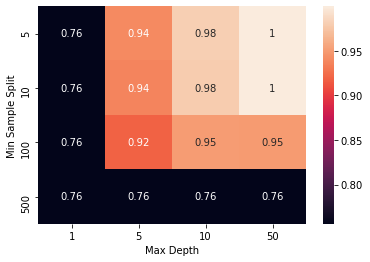

In [71]:
# Heatmap between Max Depth and Min Sample Split on Train Data
train_auc_heatmap = results.pivot("param_min_samples_split", "param_max_depth", "mean_train_score")
ax = sns.heatmap(train_auc_heatmap, annot=True)
plt.xlabel('Max Depth')
plt.ylabel('Min Sample Split')

Text(33.0, 0.5, 'Min Sample Split')

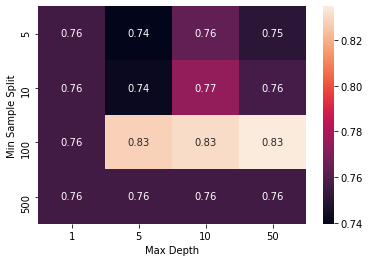

In [72]:
# Heatmap between Max Depth and Min Sample Split on Test Data
test_auc_heatmap = results.pivot("param_min_samples_split", "param_max_depth", "mean_test_score")
ax = sns.heatmap(test_auc_heatmap, annot=True)
plt.xlabel('Max Depth')
plt.ylabel('Min Sample Split')

In [73]:
# Best hyperparameters identified from the above test heatmap
best_max_depth = 10
best_min_samples_split = 100

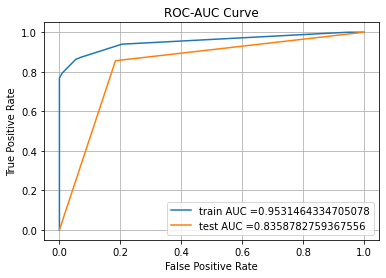

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# Final Decision Tree model using the best hyperparameters
dt_final_tfidf = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, class_weight='balanced')
dt_final_tfidf.fit(X_tr_tfidf, y_train)

y_train_pred = dt_final_tfidf.predict_proba(X_tr_tfidf)[:,1]    
y_test_pred = dt_final_tfidf.predict(X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
#plt.xscale('log')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [75]:
# we are writing our own function to predict, with defined thresold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [76]:
# Printing confusion matrix
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8166029786400156 for threshold 0.61
Train confusion matrix
[[106   6]
 [100 629]]
Test confusion matrix
[[ 31   7]
 [ 35 208]]


In [77]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

### Train Confusion Matrix

Text(33.0, 0.5, 'Actual')

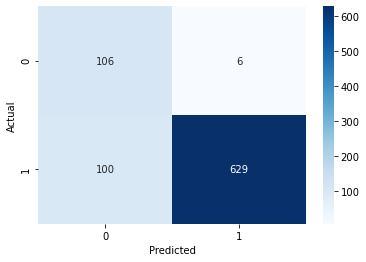

In [78]:
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Test Confusion Matrix

Text(33.0, 0.5, 'Actual')

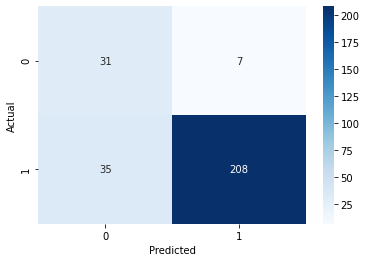

In [79]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [80]:
len(X_test['preprocessed_review_text'])

281

In [81]:
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
fpi = []
for i in range(len(y_test)) :
  if (y_test[i] == 0) & (y_test_pred[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['preprocessed_review_text'].values[i])

In [82]:
len(fpi)

7

### Word Cloud on Review Text

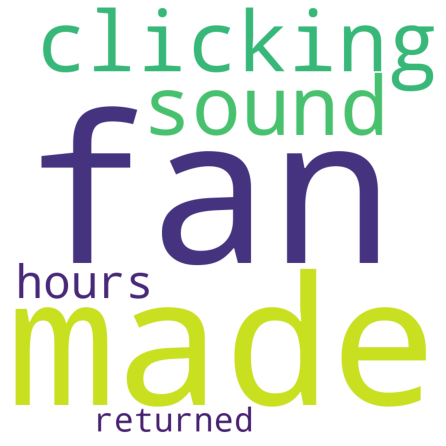

In [83]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [84]:
X_test_FP=X_test.iloc[fpi]

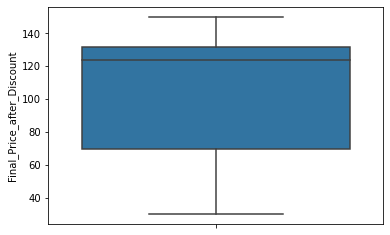

In [85]:
##Box Plot of Final Price after Discount
sns.boxplot(y='Final_Price_after_Discount', data=X_test_FP)

In [86]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth","Min Sample Split" ,"Train-AUC", "Test-AUC"]
x.add_row(["Bag of Words", "Decision Tree", 10, 100, .93, .78])
x.add_row(["TFIDF", "Decision Tree", 10, 100, .94, .83])
print(x)

+--------------+---------------+-----------+------------------+-----------+----------+
|  Vectorizer  |     Model     | Max Depth | Min Sample Split | Train-AUC | Test-AUC |
+--------------+---------------+-----------+------------------+-----------+----------+
| Bag of Words | Decision Tree |     10    |       100        |    0.93   |   0.78   |
|    TFIDF     | Decision Tree |     10    |       100        |    0.94   |   0.83   |
+--------------+---------------+-----------+------------------+-----------+----------+
